## Description
---
This notebook is for observing the velocities in the model simulations and comparing them to GlobCurrent and/or CMEMS velocity fields.

There are two kinds of model velocity fields used here. Firstly, there is the field at native model resolution. This is created by using hyc2proj on the daily means, with:
- only extracting u and v in the `extract.daily` file;
- only for the surface layer (0.00 m) in `depthlevels.in`; and
- using NCO's ncrcat to concatenate all the files into a single netcdf.

Secondly, there is the field at a resolution and grid analagous to that of GlobCurrent. In order to create the model velocities used here, `hyc2proj` is also used with:
- only extracting u and v in the `extract.daily` file;
- only for the surface layer (0.00 m) in `depthlevels.in`;
- using the exact same starting and ending lats and lons and grid spacing as GlobCurrent for a **REGULAR PROJECTION**, set in `proj.in`; and
- using NCO's ncrcat to concatenate all the files into a single netcdf.

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
import cartopy.crs as ccrs
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import xarray as xr
import cmocean.cm as cmo
import cmcrameri.cm as cmc

In [2]:
plt.rcParams['figure.facecolor']='white'
plt.rcParams['axes.facecolor']='white'

## Aside
---
Testing if the grids of HYCOM after hyc2proj match that of GlobCurrent.

In [78]:
ds_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_cci = ds_cci.sel(longitude=slice(35,38), latitude=slice(-35, -30))
ds_l2l3 = xr.open_dataset('../Data/hycom_l2l3_vel_regrid.nc')
ds_l2l3 = ds_l2l3.sel(longitude=slice(35,38), latitude=slice(-35, -30))
ds_l2l3_gridTest = xr.open_dataset('../Data/L2L3_gridTest.nc')
ds_l2l3_gridTest = ds_l2l3_gridTest.sel(longitude=slice(35,38), latitude=slice(-35, -30))
ds_l2l3_gridTest_reg = xr.open_dataset('../Data/L2L3_gridTest_regular.nc')
ds_l2l3_gridTest_reg = ds_l2l3_gridTest_reg.sel(longitude=slice(35,38), latitude=slice(-35, -30))
ds_gc = xr.open_dataset('../Data/globcurrent_surface_regional.nc')
ds_gc = ds_gc.sel(lon=slice(35,38), lat=slice(-35, -30))

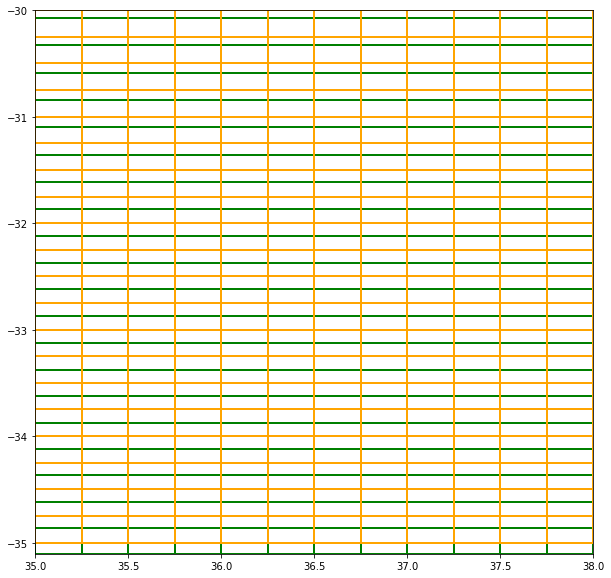

In [79]:
plt.rcParams["patch.force_edgecolor"]=True
plt.rcParams['pcolor.shading']='auto'

# plt.pcolormesh(ds_gc['lon'], ds_gc['lat'], ds_gc['eastward_eulerian_current_velocity'][0],
#                cmap=plt.get_cmap('binary_r'), edgecolor='black', facecolor=None,
#                linewidth=0.15)
fig,ax = plt.subplots(1,1,figsize=(10,10))

plt.pcolormesh(ds_gc['lon'], ds_gc['lat'], ds_gc['eastward_eulerian_current_velocity'][0],
               edgecolor='k', facecolor='none',
               linewidth=0.2)
plt.pcolormesh(ds_cci['longitude'], ds_cci['latitude'], ds_cci['u'][0].squeeze(),
               edgecolor='red', facecolor='none',
               linewidth=0.2)
# plt.pcolormesh(ds_l2l3['longitude'], ds_l2l3['latitude'], ds_l2l3['u'][0].squeeze(),
#                edgecolor='blue', facecolor='none',
#                linewidth=0.2)
plt.pcolormesh(ds_l2l3_gridTest['longitude'], ds_l2l3_gridTest['latitude'],
               ds_l2l3_gridTest['u'][0].squeeze(),
               edgecolor='green', facecolor='none',
               linewidth=0.2)
plt.pcolormesh(ds_l2l3_gridTest_reg['longitude'], ds_l2l3_gridTest_reg['latitude'],
               ds_l2l3_gridTest_reg['u'][0].squeeze(),
               edgecolor='orange', facecolor='none',
               linewidth=0.2)

In [9]:
ds_gc['time']

<xarray.DataArray 'time' (time: 1096)>
array([cftime.DatetimeJulian(2009, 3, 1, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2009, 3, 2, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2009, 3, 3, 0, 0, 0, 0, has_year_zero=False), ...,
       cftime.DatetimeJulian(2012, 2, 27, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2012, 2, 28, 0, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(2012, 2, 29, 0, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 2009-03-01 00:00:00 ... 2012-02-29 00:00:00
Attributes:
    long_name:      Time
    standard_name:  time
    axis:           T

In [10]:
ds_cci['time']

<xarray.DataArray 'time' (time: 1096)>
array(['2009-03-01T00:00:00.000000000', '2009-03-02T00:00:00.000000000',
       '2009-03-03T00:00:00.000000000', ..., '2012-02-27T00:00:00.000000000',
       '2012-02-28T00:00:00.000000000', '2012-02-29T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2009-03-01 2009-03-02 ... 2012-02-29
Attributes:
    long_name:  forecast time

---

In [5]:
def loadData(native=True):
    '''Load GlobCurrent and CMEMS velocity data. Also load model data in either
    'native' grid and resolution or on the GlobCurrent grid by setting
    'native=False'.
    
    Example usage: loadData(native=False)
    
    This function will also set a global variable that checks whether the model data
    currently loaded is in native resolution or not. This will help to ensure functions
    are always using the correct data.
    '''
    # Loading CMEMS and GlobCurrent data
    ds_cmems = xr.open_dataset('../Data/cmems_ssh.nc')
    ds_cmems = ds_cmems.sel(time=slice('2009-03','2012-02'))
    ds_cmems = ds_cmems.rename_vars({'ugos':'u', 'vgos': 'v'})
    
    ds_gc = xr.open_dataset('../Data/globcurrent_surface_regional.nc')
    ds_gc = ds_gc.sel(time=slice('2009-03','2012-02'))
    ds_gc['time'] = ds_gc.indexes['time'].to_datetimeindex() # change calendar to datetime64
    ds_gc = ds_gc.rename({'lon':'longitude', 'lat':'latitude'})
    ds_gc = ds_gc.rename_vars({'eastward_eulerian_current_velocity':'u',
                               'northward_eulerian_current_velocity': 'v'})
    
    # Set global variable to check which dataset is loaded
    global NATIVELOADED
    
    # Check to load at native or globcurrent resolution
    if native == True:
        print('Loading data at native resolution...')
        # Loading data at 'native' resolution
        ds_free = xr.open_dataset('../Data/hycom_free_vel.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
        
        ds_ostia = xr.open_dataset('../Data/hycom_ostia_vel.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
        
        ds_cci = xr.open_dataset('../Data/hycom_cci_vel.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        # ds_l2l3 = xr.open_dataset('../Data/hycom_l2l3_vel.nc')
        # ds_l2l3 = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        # ds_l2 = xr.open_dataset('../Data/hycom_l2_vel.nc')
        # ds_l2 = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        NATIVELOADED = True
        print('Done.')
        return ds_free, ds_cci, ds_cmems, ds_gc
    
    else:
        print('Loading data at GlobCurrent resolution...')
        # Loading model data interpolated to GlobCurrent grid size.
        # Also making sure that minor discrepancies in grids are ignored by setting model
        # lats and lons equal to that of GlobCurrent
        
        # load regridded HYCOM FREE dataset
        ds_free = xr.open_dataset('../Data/hycom_free_vel_regrid.nc')
        ds_free = ds_free.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM CCI dataset
        ds_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
        ds_cci = ds_cci.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM OSTIA dataset
        ds_ostia = xr.open_dataset('../Data/hycom_ostia_vel_regrid.nc')
        ds_ostia = ds_ostia.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2L3 dataset
        ds_l2l3 = xr.open_dataset('../Data/hycom_l2l3_vel_regrid.nc')
        ds_l2l3 = ds_l2l3.sel(time=slice('2009-03','2012-02'))
        
        # load regridded HYCOM L2 dataset
        ds_l2 = xr.open_dataset('../Data/hycom_l2p_vel_regrid.nc')
        ds_l2 = ds_l2.sel(time=slice('2009-03','2012-02'))
        
        NATIVELOADED = False
        print('Done.')
        return ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc

In [6]:
ds_free, ds_ostia, ds_cci, ds_l2l3, ds_l2, ds_cmems, ds_gc = loadData(native=False)

Loading data at GlobCurrent resolution...
Done.


## Calculate velocity magnitudes

In [7]:
# Determine which datasets will have a velocity field calculated
datasets = {'free':ds_free, 'cci':ds_cci, 'ostia':ds_ostia, 'l2l3':ds_l2l3,
            'l2':ds_l2, 'cmems':ds_cmems, 'globcurrent':ds_gc}

# Loop through the dictionary and create the velocity fields
for dataset in datasets:
    print(f'Now creating velocity field for: {dataset}...')
    datasets[dataset]['velocity'] = np.hypot(datasets[dataset]['u'],
                                             datasets[dataset]['v']) * 100
    print(f'Velocity field for: {dataset} completed.')
print('All done.')

Now creating velocity field for: free...
Velocity field for: free completed.
Now creating velocity field for: cci...
Velocity field for: cci completed.
Now creating velocity field for: ostia...
Velocity field for: ostia completed.
Now creating velocity field for: l2l3...
Velocity field for: l2l3 completed.
Now creating velocity field for: l2...
Velocity field for: l2 completed.
Now creating velocity field for: cmems...
Velocity field for: cmems completed.
Now creating velocity field for: globcurrent...
Velocity field for: globcurrent completed.
All done.


# Mean Velocity

In [155]:
def meanVel(simulation, simulation_name, seasonal=False):
    '''Plot mean velocity for specified simulation and optionally
    also plot seasonal means if requested.
    
    Example usage: meanVel('FREE', seasonal=True)
    '''
    # Setting plot projection
    proj = ccrs.PlateCarree()
    
    # Plot mean or seasonal means
    if seasonal == False:
        fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True,
                               subplot_kw={'projection': proj})
        
        img = simulation['velocity'].mean('time',
                                          skipna=True).plot(ax=ax,
                                                            transform=ccrs.PlateCarree(),
                                                            cmap=cmo.speed,
                                                            add_colorbar=False,
                                                            vmin=0, vmax=130)
        simulation.mean('time',
                        skipna=True).squeeze().plot.streamplot(x='longitude',
                                                               y='latitude',
                                                               u = 'u', v = 'v', ax=ax,
                                                               transform=proj,
                                                               linewidth=0.5,
                                                               arrowsize=0.3,
                                                               arrowstyle='fancy',
                                                               density=[9,3], color='white',
                                                               subplot_kws={'alpha': 0.3})
        cbar = plt.colorbar(img, ax=ax, shrink=0.6, extend='max', orientation='vertical',
                            pad=0.02)
        cbar.set_label(f'Velocity (cm.s$^{-1}$)')
        
        ax.set_title(f'{simulation_name} mean surface velocity')
        ax.coastlines()
        ax.add_feature(cartopy.feature.LAND, zorder=0,
                       facecolor='lightgrey')
    
        # gridline work
        gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
                          draw_labels=True, linestyle='dashed')
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
#         save_dir = '../Figures/vel'
#         plt.savefig(f'{save_dir}/Mean_vel_{simulation_name}.png', dpi=300,
#                     bbox_inches='tight')
    
    else:
        # Get seasonal means
        simulation = simulation.groupby('time.season').mean('time', skipna=True).squeeze()
        seasons = ['DJF', 'MAM', 'JJA', 'SON']
        
        fig, axs = plt.subplots(2, 2, figsize = (8,5), tight_layout = True,
                               subplot_kw={'projection': proj})
        axs = axs.flatten()
        fig.suptitle(f'{simulation_name} seasonal mean surface velocity')
        
        for i, ax in enumerate(axs):
            # Assign field and vector to plot
            field = simulation['velocity'].sel(season=seasons[i])
            vectors = simulation.sel(season=seasons[i])
            
            # Plot data
            img = field.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.speed,
                             add_colorbar=False, vmin=0, vmax=130)
            vectors.plot.streamplot(x='longitude', y='latitude', u = 'u', v = 'v', ax=ax,
                                    transform=proj, linewidth=0.5, arrowsize=0.3,
                                    arrowstyle='fancy', density=[9,3], color='white',
                                    subplot_kws={'alpha': 0.3})
            cbar = plt.colorbar(img, ax=ax, shrink=0.8, extend='max',
                                orientation='vertical', pad=0.02)
            cbar.set_label(f'Velocity (cm.s$^{-1}$)')
            
            ax.set_title(f'{seasons[i]}')
            ax.coastlines()
            ax.add_feature(cartopy.feature.LAND, zorder=0,
                           facecolor='lightgrey')
        
            # gridline work
            gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
                              draw_labels=True, linestyle='dashed')
            gl.top_labels = False
            gl.bottom_labels = True
            gl.right_labels = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'size': 8}
            gl.ylabel_style = {'size': 8}
                
#         save_dir = '../Figures/vel'
#         plt.savefig(f'{save_dir}/Mean_seasonal_vel_{simulation_name}.png', dpi=300,
#                     bbox_inches='tight')
    
    return

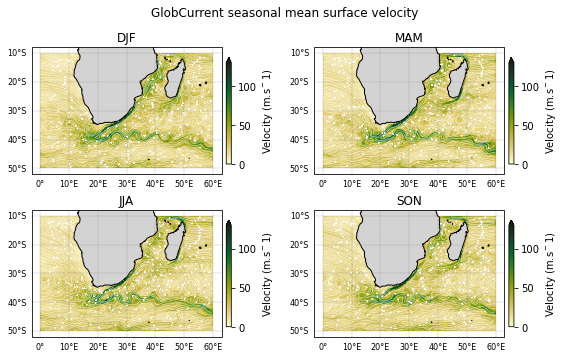

In [152]:
meanVel(ds_gc, 'GlobCurrent', seasonal=True)

# Velocity bias (vs GlobCurrent)

In [58]:
def velBias(simulation, simulation_name, seasonal=False):
    '''Plot velocity bias for specified simulation and optionally
    plot seasonal bias if requested instead.
    
    Example usage: velBias(ds_cci, 'CCI', seasonal=True)
    '''
    # Setting plot projection
    proj = ccrs.PlateCarree()
    
    # Plot total or seasonal bias
    if seasonal == False:
        fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True,
                               subplot_kw={'projection': proj})
        
        # Calculate bias
        bias = (simulation['velocity'].mean('time', skipna=True)
                - ds_gc['velocity'].mean('time', skipna=True))
        
        # Plot bias
        img = bias.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance,
                        add_colorbar=False, vmin=-80, vmax=80)
        cbar = plt.colorbar(img, ax=ax, shrink=0.6, extend='both',
                            orientation='vertical', pad=0.02)
        cbar.set_label(f'Velocity bias (cm.s$^{-1}$)')
        
        ax.set_title(f'{simulation_name} surface velocity bias')
        ax.coastlines()
        ax.add_feature(cartopy.feature.LAND, zorder=0,
                        facecolor='lightgrey')
    
        # gridline work
        gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
                          draw_labels=True, linestyle='dashed')
        gl.top_labels = False
        gl.bottom_labels = True
        gl.right_labels = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        gl.xlabel_style = {'size': 8}
        gl.ylabel_style = {'size': 8}
        
#         save_dir = '../Figures/vel'
#         plt.savefig(f'{save_dir}/Mean_vel_{simulation_name}.png', dpi=300,
#                     bbox_inches='tight')
    
    else:
        # Get seasonal means
        simulation = simulation.groupby('time.season').mean('time', skipna=True).squeeze()
        globC = ds_gc.groupby('time.season').mean('time', skipna=True).squeeze()
        seasons = ['DJF', 'MAM', 'JJA', 'SON']
        
        fig, axs = plt.subplots(2, 2, figsize = (8,5), tight_layout = True,
                                subplot_kw={'projection': proj})
        axs = axs.flatten()
        fig.suptitle(f'{simulation_name} seasonal surface velocity bias')
        
        for i, ax in enumerate(axs):
            # Calculate bias
            bias = (simulation['velocity'].sel(season=seasons[i])
                    - globC['velocity'].sel(season=seasons[i]))
            
            # Plot bias
            img = bias.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance,
                            add_colorbar=False, vmin=-80, vmax=80)
            cbar = plt.colorbar(img, ax=ax, shrink=0.8, extend='both',
                                orientation='vertical', pad=0.02)
            cbar.set_label(f'Velocity bias (cm.s$^{-1}$)')
            
            ax.set_title(f'{seasons[i]}')
            ax.coastlines()
            ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='lightgrey')
        
            # gridline work
            gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
                              draw_labels=True, linestyle='dashed')
            gl.top_labels = False
            gl.bottom_labels = True
            gl.right_labels = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER
            gl.xlabel_style = {'size': 8}
            gl.ylabel_style = {'size': 8}
                
#         save_dir = '../Figures/vel'
#         plt.savefig(f'{save_dir}/Mean_seasonal_vel_{simulation_name}.png', dpi=300,
#                     bbox_inches='tight')
    
    return

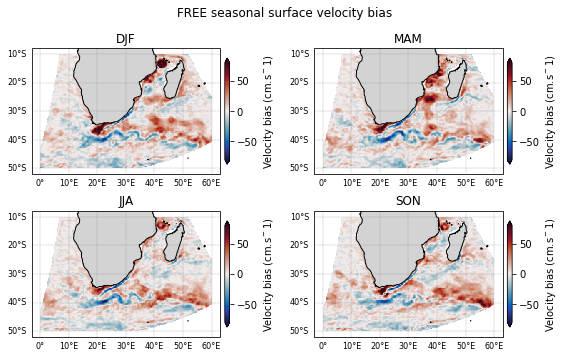

In [59]:
velBias(ds_cci, 'FREE', seasonal=True)

# Velocity RMSE (vs GlobCurrent)

In [58]:
def velRMSE(simulation, simulation_name, seasonal=False):
    '''Plot velocity RMSE for specified simulation and optionally
    plot seasonal RMSE if requested instead.
    
    Example usage: velRMSE(ds_cci, 'CCI', seasonal=True)
    '''
    # Setting plot projection
    proj = ccrs.PlateCarree()
    
    # Plot total or seasonal RMSE
#     if seasonal == False:
#         fig, ax = plt.subplots(1, 1, figsize = (5,4), tight_layout = True,
#                                subplot_kw={'projection': proj})
        
#         # Calculate bias
#         bias = simulation['velocity'].mean('time') - ds_gc['velocity'].mean('time')
        
#         # Plot bias
#         img = bias.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance,
#                         add_colorbar=False, vmin=-80, vmax=80)
#         cbar = plt.colorbar(img, ax=ax, shrink=0.6, extend='both',
#                             orientation='vertical', pad=0.02)
#         cbar.set_label(f'Velocity bias (cm.s$^{-1}$)')
        
#         ax.set_title(f'{simulation_name} surface velocity bias')
#         ax.coastlines()
#         ax.add_feature(cartopy.feature.LAND, zorder=0,
#                         facecolor='lightgrey')
    
#         # gridline work
#         gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
#                           draw_labels=True, linestyle='dashed')
#         gl.top_labels = False
#         gl.bottom_labels = True
#         gl.right_labels = False
#         gl.xformatter = LONGITUDE_FORMATTER
#         gl.yformatter = LATITUDE_FORMATTER
#         gl.xlabel_style = {'size': 8}
#         gl.ylabel_style = {'size': 8}
        
# #         save_dir = '../Figures/vel'
# #         plt.savefig(f'{save_dir}/Mean_vel_{simulation_name}.png', dpi=300,
# #                     bbox_inches='tight')
    
#     else:
#         # Get seasonal means
#         simulation = simulation.groupby('time.season').mean('time').squeeze()
#         globC = ds_gc.groupby('time.season').mean('time').squeeze()
#         seasons = ['DJF', 'MAM', 'JJA', 'SON']
        
#         fig, axs = plt.subplots(2, 2, figsize = (8,5), tight_layout = True,
#                                 subplot_kw={'projection': proj})
#         axs = axs.flatten()
#         fig.suptitle(f'{simulation_name} seasonal surface velocity bias')
        
#         for i, ax in enumerate(axs):
#             # Calculate bias
#             bias = (simulation['velocity'].sel(season=seasons[i])
#                     - globC['velocity'].sel(season=seasons[i]))
            
#             # Plot bias
#             img = bias.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmo.balance,
#                             add_colorbar=False, vmin=-80, vmax=80)
#             cbar = plt.colorbar(img, ax=ax, shrink=0.8, extend='both',
#                                 orientation='vertical', pad=0.02)
#             cbar.set_label(f'Velocity bias (cm.s$^{-1}$)')
            
#             ax.set_title(f'{seasons[i]}')
#             ax.coastlines()
#             ax.add_feature(cartopy.feature.LAND, zorder=0, facecolor='lightgrey')
        
#             # gridline work
#             gl = ax.gridlines(crs=proj, color='grey', linewidth=0.3,
#                               draw_labels=True, linestyle='dashed')
#             gl.top_labels = False
#             gl.bottom_labels = True
#             gl.right_labels = False
#             gl.xformatter = LONGITUDE_FORMATTER
#             gl.yformatter = LATITUDE_FORMATTER
#             gl.xlabel_style = {'size': 8}
#             gl.ylabel_style = {'size': 8}
                
# #         save_dir = '../Figures/vel'
# #         plt.savefig(f'{save_dir}/Mean_seasonal_vel_{simulation_name}.png', dpi=300,
# #                     bbox_inches='tight')
    
#     return

In [56]:
diff_square = (np.sum((ds_gc['velocity'] - ds_free['velocity'].squeeze()) ** 2) / count_field)**0.5
diff_square

ValueError: dimensions () must have the same length as the number of data dimensions, ndim=2

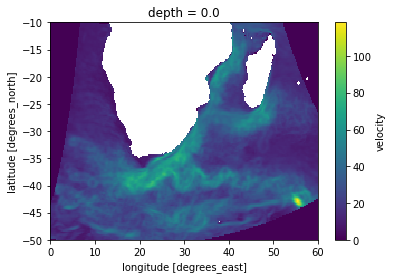

In [64]:
rmse = ((np.sum((ds_gc['velocity'] - ds_free['velocity'].squeeze()) ** 2, axis = 0)) / count_field)**0.5
rmse.plot()

In [52]:
# ds_gc['velocity'].count(dim='time')
# ds_gc.count(dim='time', skipna=True)

non_nans = (~np.isnan(ds_gc['velocity'])).sum(dim='time')

# replace 0 count with np.nan
count_field = np.where(non_nans == 0, np.nan, non_nans)

In [54]:
count_field.min()

nan

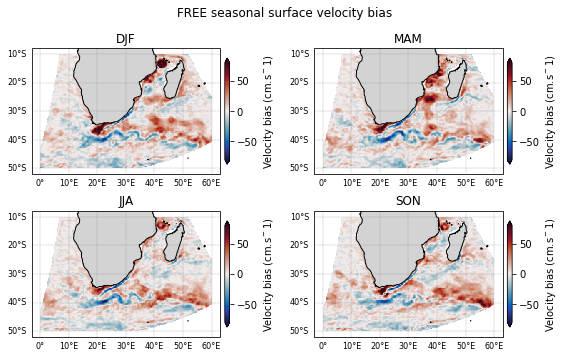

In [59]:
velBias(ds_cci, 'FREE', seasonal=True)

### HYCOM<sub>FREE</sub>

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


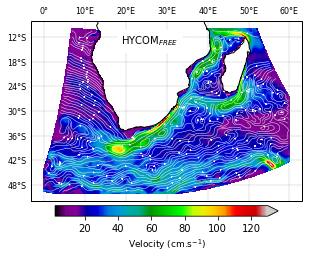

<Figure size 432x288 with 0 Axes>

In [34]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = hycom_free_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.streamplot(ds_free['longitude'].values, ds_free['latitude'].values, ds_free['u'].mean(dim='time')[0,:,:].values, ds_free['v'].mean(dim='time')[0,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_mean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

In [11]:
ds_free['u'].mean('time')

<xarray.DataArray 'u' (depth: 1, latitude: 444, longitude: 666)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 0.0 0.09022556 0.18045112 ... 59.909775 60.0
  * latitude   (latitude) float32 -50.0 -49.93051 -49.86092 ... -10.10637 -10.0
  * depth      (depth) float32 0.0

### HYCOM<sub>FREE</sub> seasonal means

In [39]:
# Group data and mean by season

ds_free_seasonal_mean = hycom_free_vel.groupby('time.season').mean('time')
ds_free_u_seasonal = ds_free['u'].groupby('time.season').mean('time')
ds_free_v_seasonal = ds_free['v'].groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


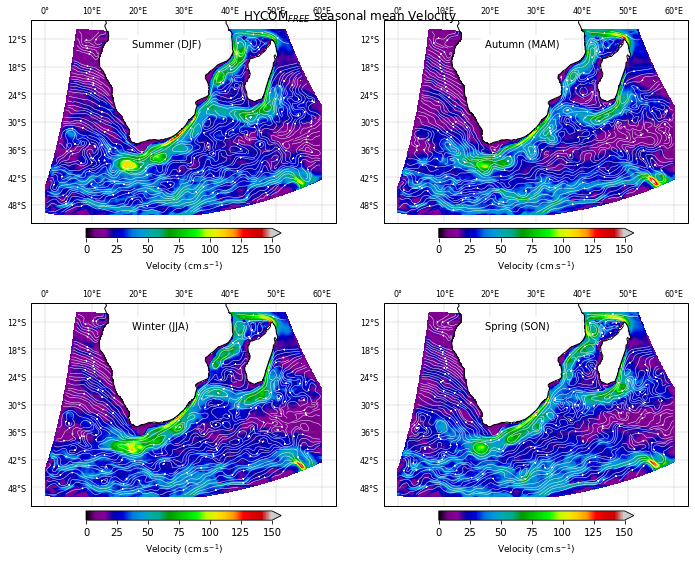

In [43]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('HYCOM$_{FREE}$ seasonal mean Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_free_seasonal_mean[s,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=150)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(ds_free_seasonal_mean['longitude'].values, ds_free_seasonal_mean['latitude'].values, ds_free_u_seasonal[s,0,:,:].values, ds_free_v_seasonal[s,0,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmean_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### HYCOM<sub>CCI</sub>

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


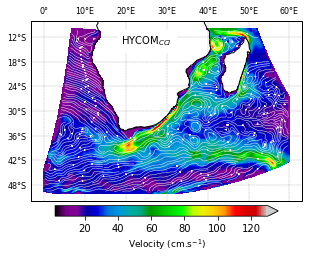

<Figure size 432x288 with 0 Axes>

In [36]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = hycom_cci_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.streamplot(ds_cci['longitude'].values, ds_cci['latitude'].values, ds_cci['u'].mean(dim='time')[0,:,:].values, ds_cci['v'].mean(dim='time')[0,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{CCI}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_mean_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### HYCOM<sub>CCI</sub> seasonal means

In [44]:
# Group data and mean by season

ds_cci_seasonal_mean = hycom_cci_vel.groupby('time.season').mean('time')
ds_cci_u_seasonal = ds_cci['u'].groupby('time.season').mean('time')
ds_cci_v_seasonal = ds_cci['v'].groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


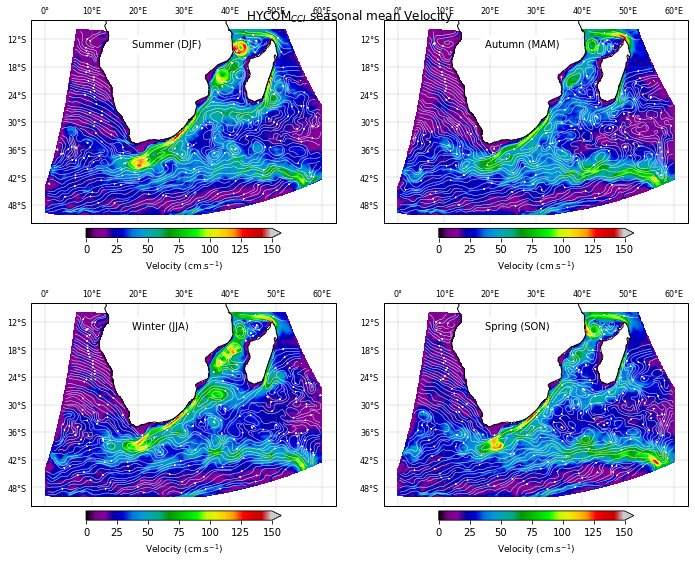

In [45]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('HYCOM$_{CCI}$ seasonal mean Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_cci_seasonal_mean[s,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=150)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(ds_cci_seasonal_mean['longitude'].values, ds_cci_seasonal_mean['latitude'].values, ds_cci_u_seasonal[s,0,:,:].values, ds_cci_v_seasonal[s,0,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmean_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### CMEMS

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


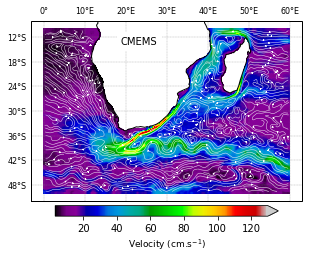

<Figure size 432x288 with 0 Axes>

In [38]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = ds_cmems_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
ax.streamplot(ds_cmems['longitude'].values, ds_cmems['latitude'].values, ds_cmems['ugos'].mean(dim='time').values, ds_cmems['vgos'].mean(dim='time').values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
plt.text(0.33,0.87,'CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_mean_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### CMEMS seasonal means

In [47]:
# Group data and mean by season

ds_cmems_seasonal_mean = ds_cmems_vel.groupby('time.season').mean('time')
ds_cmems_u_seasonal = ds_cmems['ugos'].groupby('time.season').mean('time')
ds_cmems_v_seasonal = ds_cmems['vgos'].groupby('time.season').mean('time')

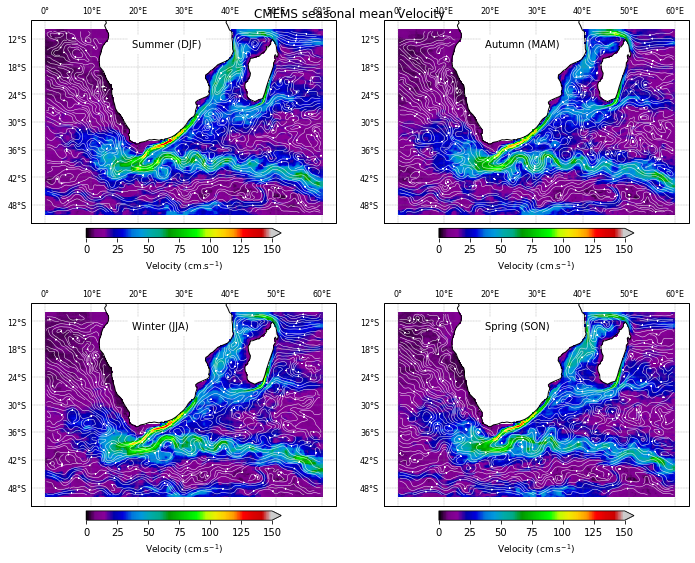

In [48]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('CMEMS seasonal mean Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_cmems_seasonal_mean[s,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=150)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(ds_cmems_seasonal_mean['longitude'].values, ds_cmems_seasonal_mean['latitude'].values, ds_cmems_u_seasonal[s,:,:].values, ds_cmems_v_seasonal[s,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmean_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### Globcurrent

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


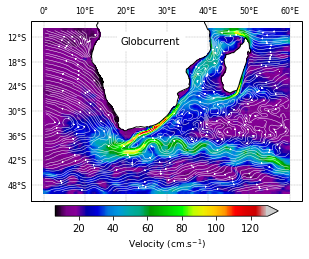

<Figure size 432x288 with 0 Axes>

In [11]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = ds_gc_vel.mean('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=130)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
ax.streamplot(ds_gc['lon'].values, ds_gc['lat'].values, ds_gc['eastward_eulerian_current_velocity'].mean(dim='time').values, ds_gc['northward_eulerian_current_velocity'].mean(dim='time').values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
plt.text(0.33,0.87,'Globcurrent', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_mean_Globcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Globcurrent seasonal means

In [12]:
# Group data and mean by season

ds_gc_seasonal_mean = ds_gc_vel.groupby('time.season').mean('time')
ds_gc_u_seasonal = ds_gc['eastward_eulerian_current_velocity'].groupby('time.season').mean('time')
ds_gc_v_seasonal = ds_gc['northward_eulerian_current_velocity'].groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


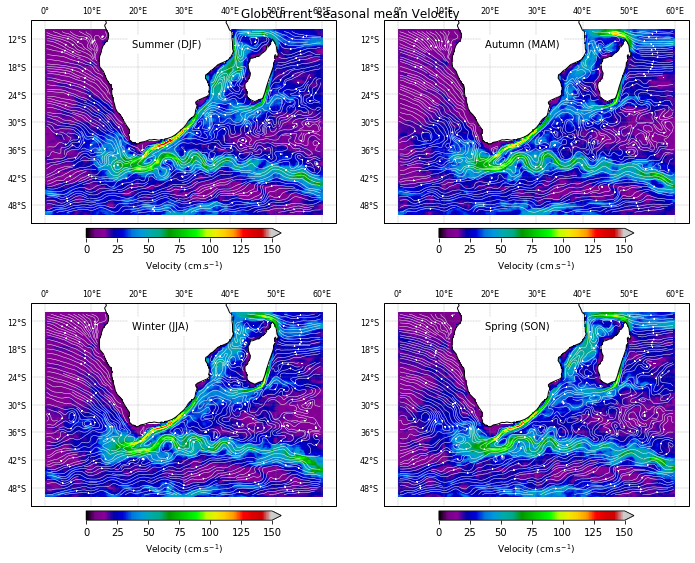

In [14]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('Globcurrent seasonal mean Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_gc_seasonal_mean[s,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=150)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(ds_gc_seasonal_mean['lon'].values, ds_gc_seasonal_mean['lat'].values, ds_gc_u_seasonal[s,:,:].values, ds_gc_v_seasonal[s,:,:].values, transform=proj, linewidth=0.5, arrowsize=0.3, arrowstyle='fancy', density=[9,3], color='white')
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmean_Globcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - HYCOM<sub>FREE</sub>) mean Vel

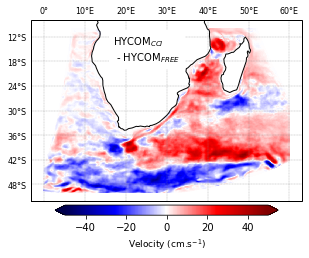

<Figure size 432x288 with 0 Axes>

In [15]:
proj = ccrs.PlateCarree()

diff = hycom_cci_vel.mean('time') - hycom_free_vel.mean('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-50, vmax=50)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_meandiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - HYCOM<sub>FREE</sub>) seasonal mean Velocity

In [17]:
# Group data and mean by season

ds_free_seasonal_mean = hycom_free_vel.groupby('time.season').mean('time')
ds_cci_seasonal_mean = hycom_cci_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


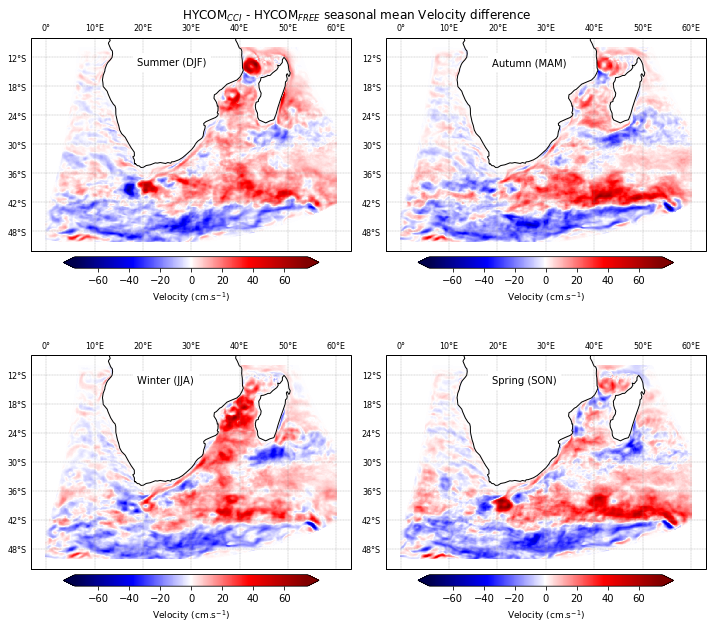

In [18]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - HYCOM$_{FREE}$ seasonal mean Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_seasonal_mean[s,0,:,:] - ds_free_seasonal_mean[s,0,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-75, vmax=75)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmeandiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - CMEMS ) mean Velocity

In [45]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_cmems_vel['latitude']
ds_regrid_hycom_cci['longitude'] = ds_cmems_vel['longitude']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_mean = hycom_cci_regrid_vel.groupby('time.season').mean('time')
ds_cmems_seasonal_mean = ds_cmems_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


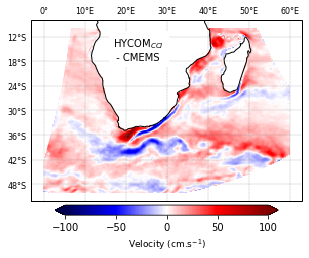

<Figure size 432x288 with 0 Axes>

In [46]:
proj = ccrs.PlateCarree()

diff = hycom_cci_regrid_vel.mean('time') - ds_cmems_vel.mean('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-100, vmax=100)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_meandiff_HYCOMcciCMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - CMEMS) seasonal mean Velocity

In [21]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_cmems_vel['latitude']
ds_regrid_hycom_cci['longitude'] = ds_cmems_vel['longitude']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_mean = hycom_cci_regrid_vel.groupby('time.season').mean('time')
ds_cmems_seasonal_mean = ds_cmems_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


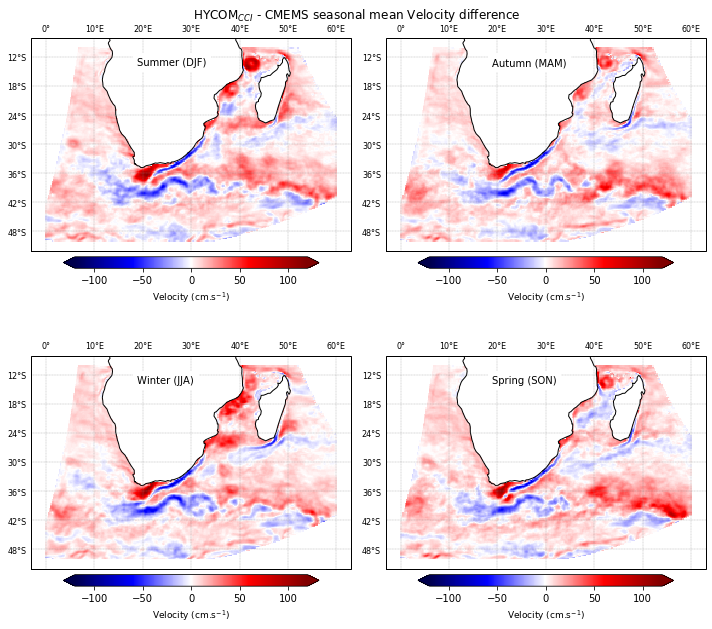

In [22]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - CMEMS seasonal mean Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_regrid_seasonal_mean[s,0,:,:] - ds_cmems_seasonal_mean[s,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-120, vmax=120)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmeandiff_HYCOMcciCMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### Difference (HYCOM<sub>FREE</sub> - Globcurrent ) mean Velocity

In [35]:
# load regridded HYCOM free dataset

ds_regrid_hycom_free = xr.open_dataset('../Data/hycom_free_vel_regrid.nc')
ds_regrid_hycom_free = ds_regrid_hycom_free.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_free = ds_regrid_hycom_free.rename({'longitude': 'lon','latitude': 'lat'})
ds_regrid_hycom_free['lat'] = ds_gc_vel['lat']
ds_regrid_hycom_free['lon'] = ds_gc_vel['lon']

# calculate HYCOM free regrid velocity magnitudes

hycom_free_regrid_vel = np.hypot(ds_regrid_hycom_free['u'],ds_regrid_hycom_free['v'])*100

# Group data and mean by season

ds_free_regrid_seasonal_mean = hycom_free_regrid_vel.groupby('time.season').mean('time')
ds_gc_seasonal_mean = ds_gc_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


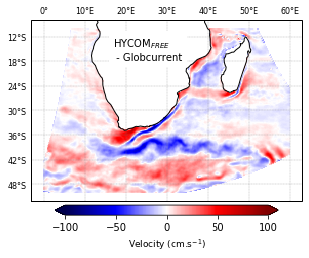

<Figure size 432x288 with 0 Axes>

In [37]:
proj = ccrs.PlateCarree()

diff = hycom_free_regrid_vel.mean('time') - ds_gc_vel.mean('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-100, vmax=100)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{FREE}$\n - Globcurrent', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_meandiff_HYCOMfreeGlobcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>FREE</sub> - Globcurrent) seasonal mean Velocity

In [38]:
# load regridded HYCOM free dataset

ds_regrid_hycom_free = xr.open_dataset('../Data/hycom_free_vel_regrid.nc')
ds_regrid_hycom_free = ds_regrid_hycom_free.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_free = ds_regrid_hycom_free.rename({'longitude': 'lon','latitude': 'lat'})
ds_regrid_hycom_free['lat'] = ds_gc_vel['lat']
ds_regrid_hycom_free['lon'] = ds_gc_vel['lon']

# calculate HYCOM free regrid velocity magnitudes

hycom_free_regrid_vel = np.hypot(ds_regrid_hycom_free['u'],ds_regrid_hycom_free['v'])*100

# Group data and mean by season

ds_free_regrid_seasonal_mean = hycom_free_regrid_vel.groupby('time.season').mean('time')
ds_gc_seasonal_mean = ds_gc_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


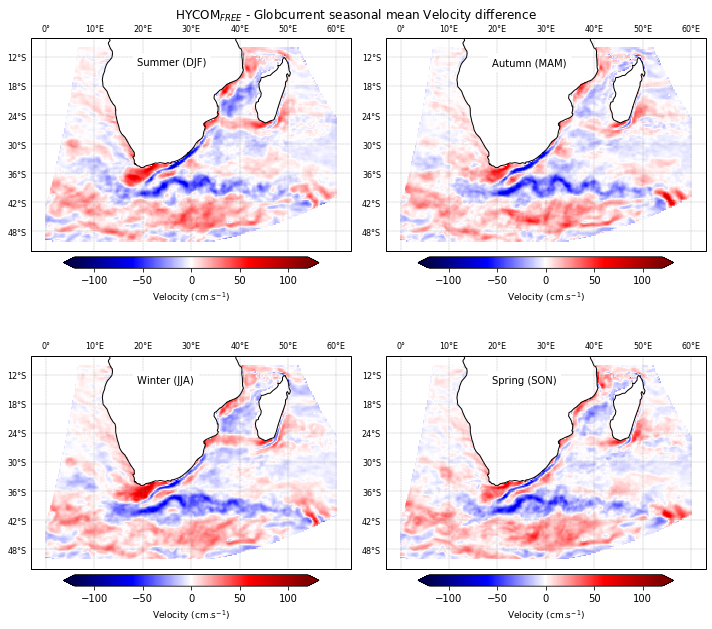

In [40]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{FREE}$ - Globcurrent seasonal mean Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_free_regrid_seasonal_mean[s,0,:,:] - ds_gc_seasonal_mean[s,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-120, vmax=120)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmeandiff_HYCOMfreeGlobcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

### Difference (HYCOM<sub>FREE</sub> - Globcurrent ) mean Velocity

In [42]:
# load regridded HYCOM cci dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci = ds_regrid_hycom_cci.rename({'longitude': 'lon','latitude': 'lat'})
ds_regrid_hycom_cci['lat'] = ds_gc_vel['lat']
ds_regrid_hycom_cci['lon'] = ds_gc_vel['lon']

# calculate HYCOM cci regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_mean = hycom_cci_regrid_vel.groupby('time.season').mean('time')
ds_gc_seasonal_mean = ds_gc_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


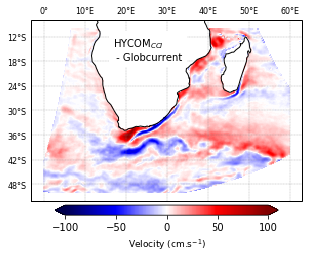

<Figure size 432x288 with 0 Axes>

In [44]:
proj = ccrs.PlateCarree()

diff = hycom_cci_regrid_vel.mean('time') - ds_gc_vel.mean('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-100, vmax=100)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - Globcurrent', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_meandiff_HYCOMcciGlobcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - Globcurrent) seasonal mean Velocity

In [32]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci = ds_regrid_hycom_cci.rename({'longitude': 'lon','latitude': 'lat'})
ds_regrid_hycom_cci['lat'] = ds_gc_vel['lat']
ds_regrid_hycom_cci['lon'] = ds_gc_vel['lon']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_mean = hycom_cci_regrid_vel.groupby('time.season').mean('time')
ds_gc_seasonal_mean = ds_gc_vel.groupby('time.season').mean('time')

/home/harry/miniconda3/lib/python3.7/site-packages/xarray/core/nanops.py:159: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


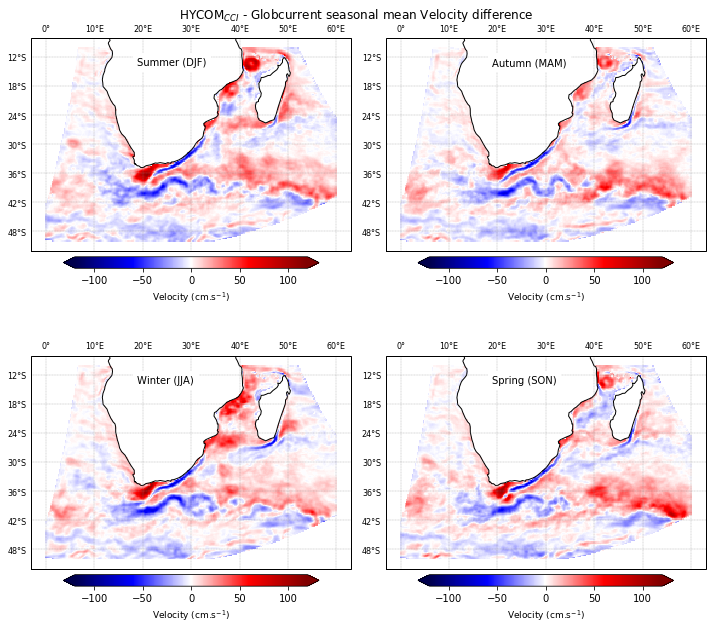

In [34]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - Globcurrent seasonal mean Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_regrid_seasonal_mean[s,0,:,:] - ds_gc_seasonal_mean[s,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-120, vmax=120)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalmeandiff_HYCOMcciGlobcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

# StDev Velocity

## HYCOM<sub>FREE</sub>

### Standard Devation

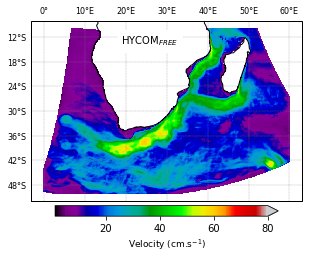

<Figure size 432x288 with 0 Axes>

In [16]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = hycom_free_vel.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=80)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdev_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Seasonal standard deviation

In [19]:
# Group data and calculate stdev by season

ds_free_seasonal_stdev = hycom_free_vel.groupby('time.season').std('time')

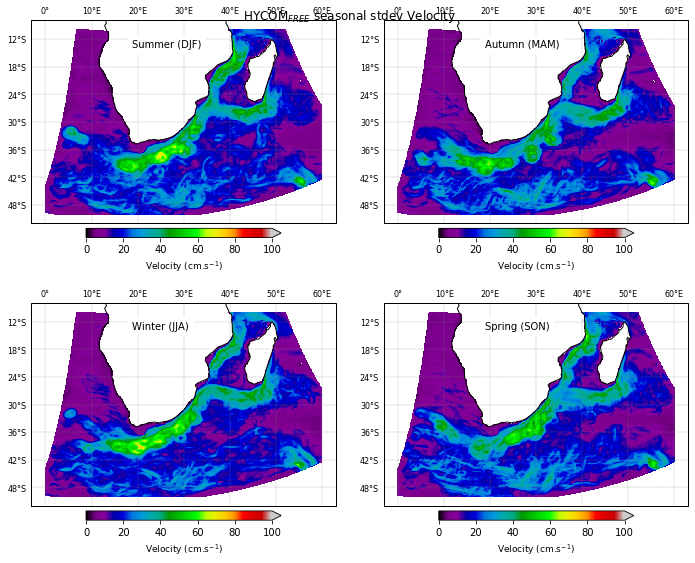

In [53]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('HYCOM$_{FREE}$ seasonal stdev Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_free_seasonal_stdev[s,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=100)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdev_HYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## HYCOM<sub>CCI</sub>

### Standard Devation

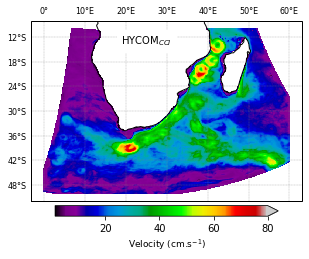

<Figure size 432x288 with 0 Axes>

In [14]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = hycom_cci_vel.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=80)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'HYCOM$_{CCI}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdev_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Seasonal standard deviation

In [25]:
# Group data and mean by season

ds_cci_seasonal_stdev = hycom_cci_vel.groupby('time.season').std('time')

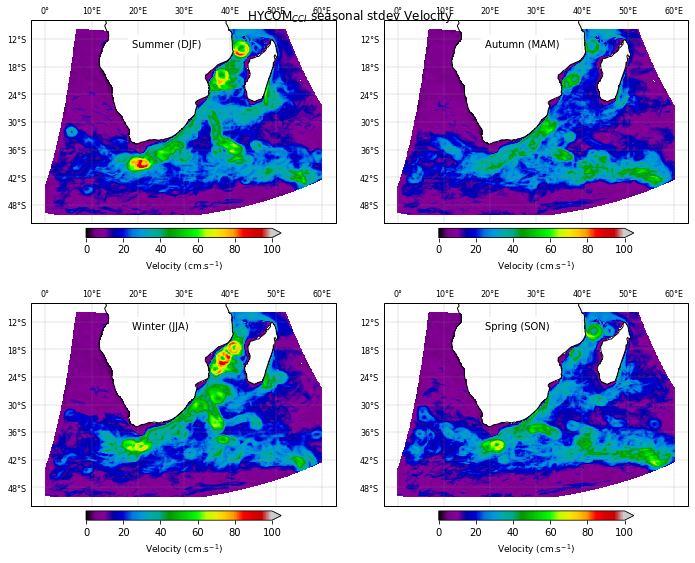

In [54]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('HYCOM$_{CCI}$ seasonal stdev Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_cci_seasonal_stdev[s,0,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=100)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdev_HYCOMcci.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## CMEMS

### Standard Devation

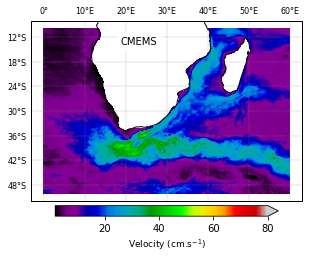

<Figure size 432x288 with 0 Axes>

In [15]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = ds_cmems_vel.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=80)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdev_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Seasonal standard deviation

In [30]:
# Group data and mean by season

ds_cmems_seasonal_stdev = ds_cmems_vel.groupby('time.season').std('time')

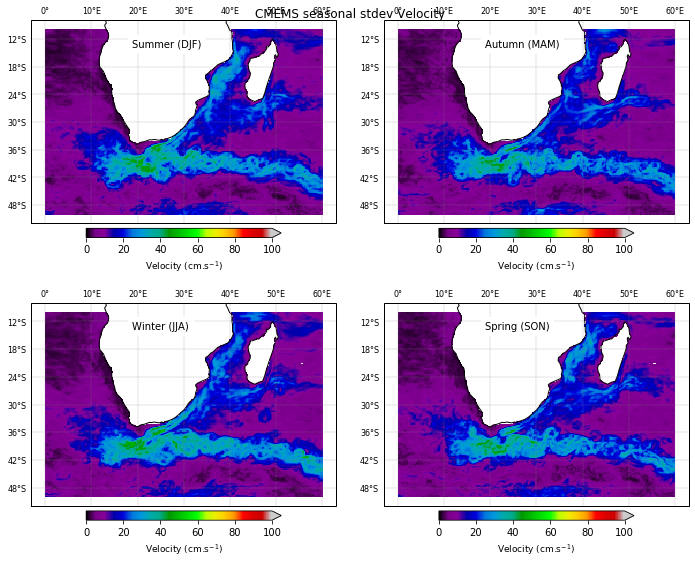

In [55]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('CMEMS seasonal stdev Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_cmems_seasonal_stdev[s,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=100)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdev_CMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Globcurrent

### Standard Devation

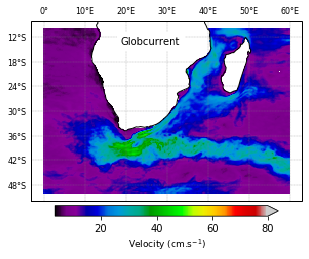

<Figure size 432x288 with 0 Axes>

In [7]:
proj = ccrs.PlateCarree()

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = ds_gc_vel.std('time').plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmax=80)
cbar = plt.colorbar(img, shrink=0.8, extend='max', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.33,0.87,'Globcurrent', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdev_Globcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Seasonal standard deviation

In [8]:
# Group data and mean by season

ds_gc_seasonal_stdev = ds_gc_vel.groupby('time.season').std('time')

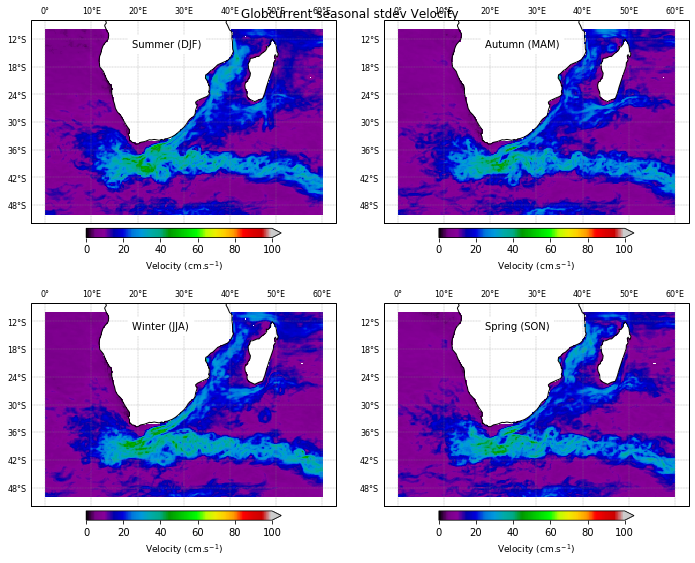

In [10]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,8))
fig.suptitle('Globcurrent seasonal stdev Velocity')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    img = ds_gc_seasonal_stdev[s,:,:].plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=100)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdev_Globcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Difference (HYCOM<sub>CCI</sub> - HYCOM<sub>FREE</sub>) mean Vel

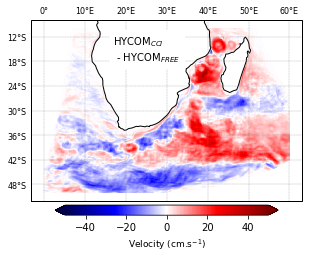

<Figure size 432x288 with 0 Axes>

In [37]:
proj = ccrs.PlateCarree()

diff = hycom_cci_vel.std('time') - hycom_free_vel.std('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-50, vmax=50)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - HYCOM$_{FREE}$', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdevdiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

## Difference (HYCOM<sub>CCI</sub> - HYCOM<sub>FREE</sub>) seasonal mean Velocity

In [38]:
# Group data and mean by season

ds_free_seasonal_stdev = hycom_free_vel.groupby('time.season').std('time')
ds_cci_seasonal_stdev = hycom_cci_vel.groupby('time.season').std('time')

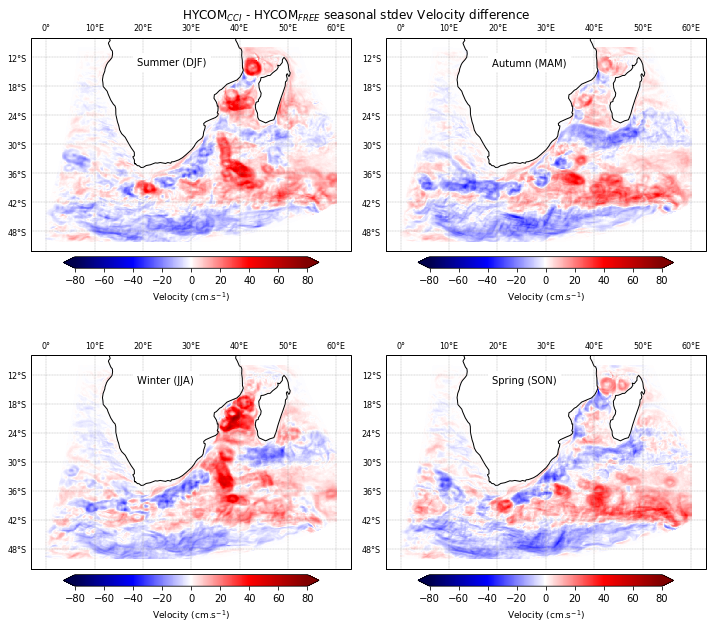

In [56]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - HYCOM$_{FREE}$ seasonal stdev Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_seasonal_stdev[s,0,:,:] - ds_free_seasonal_stdev[s,0,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-80, vmax=80)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdevdiff_HYCOMcciHYCOMfree.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Difference (HYCOM<sub>CCI</sub> - CMEMS ) mean Velocity

In [47]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_cmems_vel['latitude']
ds_regrid_hycom_cci['longitude'] = ds_cmems_vel['longitude']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_stdev = hycom_cci_regrid_vel.groupby('time.season').std('time')
ds_cmems_seasonal_stdev = ds_cmems_vel.groupby('time.season').std('time')

/home/harry/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


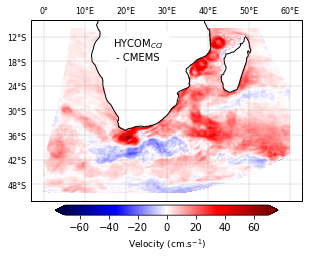

<Figure size 432x288 with 0 Axes>

In [49]:
proj = ccrs.PlateCarree()

diff = hycom_cci_regrid_vel.std('time') - ds_cmems_vel.std('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-70, vmax=70)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - CMEMS', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
plt.savefig('../Figures/vel/VEL_stdevdiff_HYCOMcciCMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - CMEMS) seasonal stdev Velocity

In [50]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_cmems_vel['latitude']
ds_regrid_hycom_cci['longitude'] = ds_cmems_vel['longitude']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_stdev = hycom_cci_regrid_vel.groupby('time.season').std('time')
ds_cmems_seasonal_stdev = ds_cmems_vel.groupby('time.season').std('time')

/home/harry/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


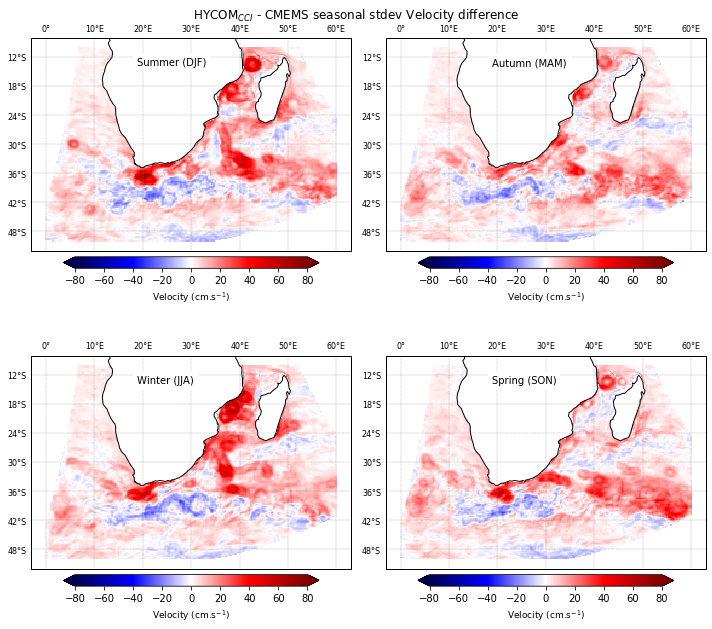

In [57]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - CMEMS seasonal stdev Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_regrid_seasonal_stdev[s,0,:,:] - ds_cmems_seasonal_stdev[s,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-80, vmax=80)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdevdiff_HYCOMcciCMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

## Difference (HYCOM<sub>CCI</sub> - Globcurrent ) mean Velocity

In [12]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_gc_vel['lat']
ds_regrid_hycom_cci['longitude'] = ds_gc_vel['lon']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_stdev = hycom_cci_regrid_vel.groupby('time.season').std('time')
ds_gc_seasonal_stdev = ds_gc_vel.groupby('time.season').std('time')

/home/harry/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


AttributeError: 'Rectangle' object has no property 'cmap'

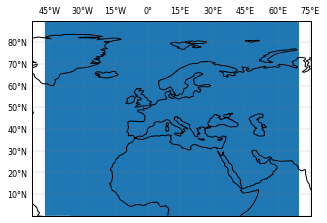

In [13]:
proj = ccrs.PlateCarree()

diff = hycom_cci_regrid_vel.std('time') - ds_gc_vel.std('time')

plt.figure(figsize=(5,4))
ax = plt.axes(projection=proj)
ax.coastlines()

# gridline work
gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
gl.xlabels_top = True
gl.xlabels_bottom = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 8}
gl.ylabel_style = {'size': 8}

img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-70, vmax=70)
cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
ax.set_title('')
plt.text(0.30,0.78,'HYCOM$_{CCI}$\n - Globcurrent', bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
# plt.savefig('../Figures/vel/VEL_stdevdiff_HYCOMcciGlobcurrent.png', dpi=300, bbox_inches='tight', format='png')
plt.show()
plt.tight_layout()

### Difference (HYCOM<sub>CCI</sub> - CMEMS) seasonal stdev Velocity

In [50]:
# load regridded HYCOM CCI dataset

ds_regrid_hycom_cci = xr.open_dataset('../Data/hycom_cci_vel_regrid.nc')
ds_regrid_hycom_cci = ds_regrid_hycom_cci.sel(time=slice('2009-01-01','2014-06-04'))

# ensure lats and lons are exactly the same
ds_regrid_hycom_cci['latitude'] = ds_cmems_vel['latitude']
ds_regrid_hycom_cci['longitude'] = ds_cmems_vel['longitude']

# calculate HYCOM CCI regrid velocity magnitudes

hycom_cci_regrid_vel = np.hypot(ds_regrid_hycom_cci['u'],ds_regrid_hycom_cci['v'])*100

# Group data and mean by season

ds_cci_regrid_seasonal_stdev = hycom_cci_regrid_vel.groupby('time.season').std('time')
ds_cmems_seasonal_stdev = ds_cmems_vel.groupby('time.season').std('time')

/home/harry/miniconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1666: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


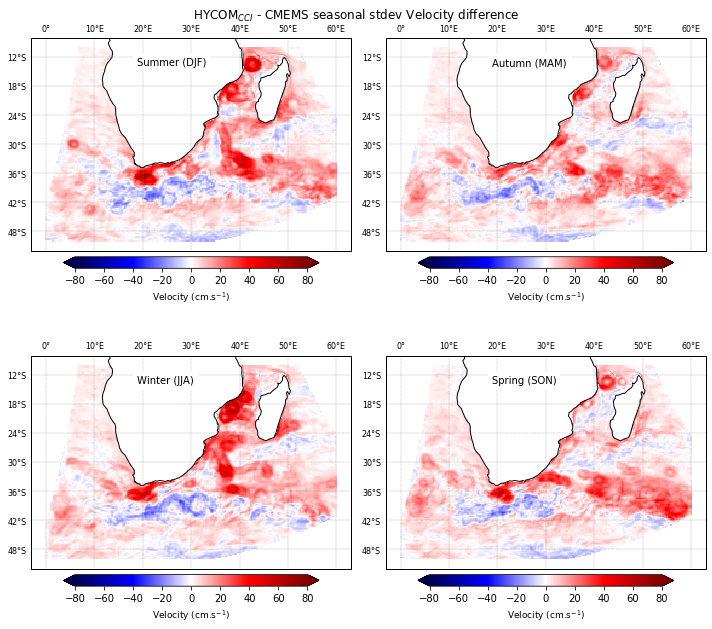

In [57]:
proj = ccrs.PlateCarree()
seasons = ['Summer (DJF)', 'Autumn (MAM)', 'Winter (JJA)', 'Spring (SON)']

fig = plt.figure(figsize=(10,9))
fig.suptitle('HYCOM$_{CCI}$ - CMEMS seasonal stdev Velocity difference')

for s, i in enumerate(seasons):
    
    ax = plt.subplot(2,2,s+1,projection=proj)
    
    diff = ds_cci_regrid_seasonal_stdev[s,0,:,:] - ds_cmems_seasonal_stdev[s,:,:]
    
    img = diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('seismic'), add_colorbar=False, vmin=-80, vmax=80)
    cbar = plt.colorbar(img, shrink=0.8, extend='both', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(i), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/vel/VEL_seasonalstdevdiff_HYCOMcciCMEMS.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

###  ======================================================

In [4]:
# selecting max and min ACT days
max_day = '2011-09-28'
min_day = '2011-07-03'

ds_cci_maxvels = ds_cci.sel(time=max_day).squeeze()
ds_cci_max = np.hypot(ds_cci_maxvels['u'],ds_cci_maxvels['v'])*100
ds_cci_minvels = ds_cci.sel(time=min_day).squeeze()
ds_cci_min = np.hypot(ds_cci_minvels['u'],ds_cci_minvels['v'])*100

ds_free_maxvels = ds_free.sel(time=max_day).squeeze()
ds_free_max = np.hypot(ds_free_maxvels['u'],ds_free_maxvels['v'])*100
ds_free_minvels = ds_free.sel(time=min_day).squeeze()
ds_free_min = np.hypot(ds_free_minvels['u'],ds_free_minvels['v'])*100

ds_gc_maxvels = ds_gc.sel(time=max_day).squeeze()
ds_gc_max = np.hypot(ds_gc_maxvels['eastward_eulerian_current_velocity'],ds_gc_maxvels['northward_eulerian_current_velocity'])*100
ds_gc_minvels = ds_gc.sel(time=min_day).squeeze()
ds_gc_min = np.hypot(ds_gc_minvels['eastward_eulerian_current_velocity'],ds_gc_minvels['northward_eulerian_current_velocity'])*100
ds_gc_maxvels = ds_gc_maxvels.rename({'lon':'longitude', 'lat': 'latitude', 'eastward_eulerian_current_velocity': 'u', 'northward_eulerian_current_velocity': 'v'})
ds_gc_minvels = ds_gc_minvels.rename({'lon':'longitude', 'lat': 'latitude', 'eastward_eulerian_current_velocity': 'u', 'northward_eulerian_current_velocity': 'v'})

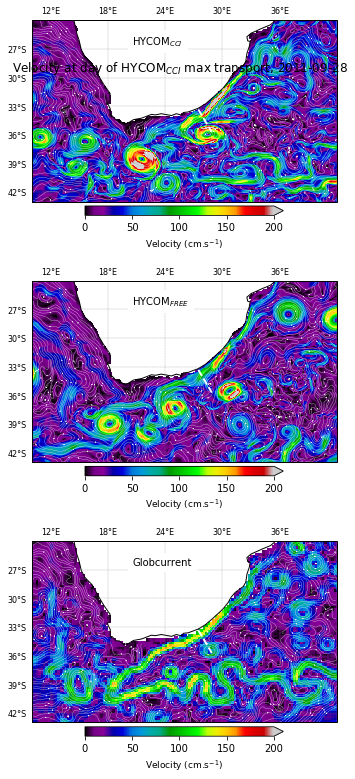

In [12]:
proj = ccrs.PlateCarree()
dataset = [ds_cci_max, ds_free_max, ds_gc_max]
ds_names = ['HYCOM$_{CCI}$','HYCOM$_{FREE}$','Globcurrent']
stream_refs = [ds_cci_maxvels, ds_free_maxvels, ds_gc_maxvels]

fig = plt.figure(figsize=(5,11))
fig.suptitle('Velocity at day of HYCOM$_{CCI}$ max transport, 2011-09-28', y=0.92)

for s, i in enumerate(dataset):
    
    ax = plt.subplot(3,1,s+1,projection=proj)
    ax.set_extent((10, 42, -42, -24))
    
    img = i.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=200)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(stream_refs[s]['longitude'].values, stream_refs[s]['latitude'].values, stream_refs[s]['u'].values, stream_refs[s]['v'].values, transform=proj, linewidth=0.3, arrowsize=0.2, arrowstyle='fancy', density=[9,3], color='white')
    ax.plot([27.4808, 28.9000], [-33.3438, -35.7338], color='white', linewidth=1.9, linestyle='dashed',  transform=ccrs.Geodetic())
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(ds_names[s]), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/act/Vel_HYCOMcciMaximum.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()

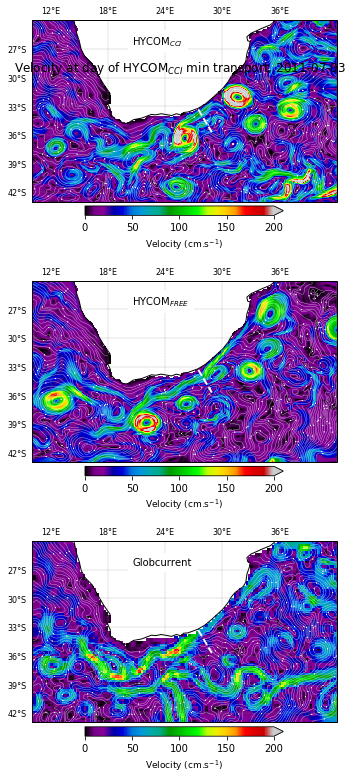

In [13]:
proj = ccrs.PlateCarree()
dataset = [ds_cci_min, ds_free_min, ds_gc_min]
ds_names = ['HYCOM$_{CCI}$','HYCOM$_{FREE}$','Globcurrent']
stream_refs = [ds_cci_minvels, ds_free_minvels, ds_gc_minvels]

fig = plt.figure(figsize=(5,11))
fig.suptitle('Velocity at day of HYCOM$_{CCI}$ min transport, 2011-07-03', y=0.92)

for s, i in enumerate(dataset):
    
    ax = plt.subplot(3,1,s+1,projection=proj)
    ax.set_extent((10, 42, -42, -24))
    
    img = i.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=plt.get_cmap('nipy_spectral'), add_colorbar=False, vmin=0, vmax=200)
    cbar = plt.colorbar(img, shrink=0.6, extend='max', orientation='horizontal', pad=0.02)
    cbar.set_label('Velocity (cm.s$^{-1}$)', fontsize=9)
    ax.streamplot(stream_refs[s]['longitude'].values, stream_refs[s]['latitude'].values, stream_refs[s]['u'].values, stream_refs[s]['v'].values, transform=proj, linewidth=0.3, arrowsize=0.2, arrowstyle='fancy', density=[9,3], color='white')
    ax.plot([27.4808, 28.9000], [-33.3438, -35.7338], color='white', linewidth=1.9, linestyle='dashed',  transform=ccrs.Geodetic())
    ax.coastlines()
    
    # gridline work
    gl = ax.gridlines(crs=ccrs.PlateCarree(), color='grey', linewidth=0.3, draw_labels=True, linestyle='dashed')
    gl.xlabels_top = True
    gl.xlabels_bottom = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 8}
    gl.ylabel_style = {'size': 8}
    
    ax.text(0.33,0.87,'{0}'.format(ds_names[s]), bbox=dict(facecolor='white', edgecolor='white', alpha=1), fontsize=10, transform=ax.transAxes)
    ax.set_title('')
    
plt.savefig('../Figures/act/Vel_HYCOMcciMinimum.png', dpi=300, bbox_inches='tight', format='png')
plt.plot()
fig.canvas.draw()
fig.tight_layout()